[![logo](https://climate.copernicus.eu/sites/default/files/custom-uploads/branding/LogoLine_horizon_C3S.png)](https://climate.copernicus.eu)

# Working with the GTSMip dataset of global tides and surges

**This notebook can be run on free online platforms, such as Binder, Kaggle and Colab, or they can be accessed from GitHub. The links to run this notebook in these environments are provided here, but please note they are not supported by ECMWF.** 

[![binder](https://mybinder.org/badge.svg)](https://mybinder.org/v2/gh/ecmwf-training/c3s-training-submodule-climate-indices/main?labpath=gtsmip-water-levels.ipynb)
[![kaggle](https://kaggle.com/static/images/open-in-kaggle.svg)](https://kaggle.com/kernels/welcome?src=https://github.com/ecmwf-training/c3s-training-submodule-climate-indices/blob/main/gtsmip-water-levels.ipynb)
[![colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ecmwf-training/c3s-training-submodule-climate-indices/blob/main/gtsmip-water-levels.ipynb)
[![github](https://img.shields.io/badge/Open%20in-GitHub-black?logo=github)](https://github.com/ecmwf-training/c3s-training-submodule-climate-indices/blob/main/gtsmip-water-levels.ipynb)


## Introduction

This notebook provides a practical introduction on how to access, visualize and analyse [GTSMip tide and surge water level timeseries](https://cds.climate.copernicus.eu/datasets/sis-water-level-change-timeseries-cmip6?tab=overview) data available in the Climate Data Store (CDS) of the Copernicus Climate Change Service (C3S), developed by Deltares in order to accompany the dataset. This data is the output of the the global tide and surge model [GTSMv3.0](https://www.deltares.nl/en/expertise/projects/global-modelling-of-tides-and-storm-surges). 

The GTSMip dataset on CDS includes total water level, surge and tidal elevation timeseries, as well as annual mean sea level values (based on sea level rise projections). Next to the reanalysis data forced with ERA5, also model timeseries forced with several high-resolution climate models (HighResMIP) are available for the period of 1950 to 2050. The timeseries are available for a large number of offshore and coastal locations (over 43.000 locations globally). For more information on the full dataset, please refer to the [Product User Guide](https://cds.climate.copernicus.eu/datasets/sis-water-level-change-timeseries-cmip6?tab=documentation).

In this notebook we use the data from the GTSM `reanalysis` experiment where the surges were generated using the ERA5 meteorological reanalysis. This data is available for the period from 1950 onwards. We use the reanalysis experiment data to explore historical storm events. Reanalysis experiment data is useful for analyzing the contribution of surge to high coastal water levels, and as input for hydrodynamic modelling on local scale, including scenario modelling.

### Data description

This notebook introduces you to the [GTSMip tide and surge water level timeseries](https://cds.climate.copernicus.eu/datasets/sis-water-level-change-timeseries-cmip6?tab=overview). The datasets used in the notebook have the following specifications:

> **Variable**: mean sea level, storm residual, tidal elevation and total water level <br>
> **Experiment**: Historical, future or reanalysis <br>
> **Model**: climate models (not applicable to reanalysis data) <br>
> **Temporal aggregation**: temporal frequency of the data: hourly, 10-min or daily maxima <br>
> **Year**: Selection of year, for reanalysis model output 1950 to 2023 are available <br>
> **Month**: selection of months (January to December) <br>

## Prepare your environment

### Setup the CDSAPI and your credentials

The code below will ensure that the `cdsapi` package is installed. If you have not setup your `~/.cdsapirc` file with your credenials, you can replace `None` with your credentials that can be found on the [how to api](https://cds.climate.copernicus.eu/how-to-api) page (you will need to log in to see your credentials).

In [ ]:
!pip install -q cdsapi
# If you have already setup your .cdsapirc file you can leave this as None
cdsapi_key = None
cdsapi_url = None

### Install and import libraries

The following code block will import the python modules required for this notebook. We will be using cdsapi for downloading the data and xarray for handling the data, and matplotlib and cartopy for plotting.

In [3]:
# General libraries for file paths, data extraction, etc
from glob import glob
import os
import zipfile
import urllib3

# CDS API
import cdsapi

# Libraries for working with multi-dimensional arrays
import numpy as np
import xarray as xr

# Libraries for plotting and visualising data
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Libraries for dealing with time variables
from datetime import datetime

urllib3.disable_warnings()  # Disable warnings for data download via API

### Setup directories to store the data and output

In [ ]:
DATADIR = './data_dir/'
if not os.path.exists(DATADIR):
    os.makedirs(DATADIR)

OUTDIR = os.path.join(DATADIR, 'output')
if not os.path.exists(OUTDIR):
    os.makedirs(OUTDIR)

## Select and retrieve data from the CDS using the CDS API

### Select storm event and location of interest

First we need to specify the directories in which we can download our data and store the outputs:

For the purposes of this exercize, we focus on a past event that led to high coastal water levels and increased risk of flooding. We specify the name of the storm, its year and the coordinates of a coastal location where we would like to see the water level data, as well as the timeframe for visualization (needs to correspond to the period in which the storm impact has occurred). 

Below three options were prepared already, and you can select the storm to be visualized in this notebook by changing the `storm` variable. The options pre-defined below are storms Xyntia (2010), Ciara (2020) and Pia (2023). However, as a user you can add custom options for other storms and locations by adding year and coordinates of the location of interest, as well as the timeframe that the user would like to visualize. The coordinates are used to snap to the nearest model output location. Please note, that the coordinates need to be located at the open coast (i.e. not inside a narrow eastuary), keeping in mind that GTSM is a global model with a coastal resolution of 1.25 km along European coasts. For a visualization of the available output points from GTSM see the plots that are generated further on in this notebook.

We have selected storms Xyntia (2010), Ciara (2020) and Pia (2023) to illustrate the analysis of the global tide and surge model data because these storms are relatively recent and had significant impact on the European coasts.

**Storm Xyntia (2010)** was an exceptionally violent storm that impacted Western European countries in the end of February to beginning of March 2010. In terms of coastal impacts, the storm has caused most destructive impact at the western coast of France, in the area surrounding La Rochelle (departments Vendée and Charente-Maritime). The coastal water levels were exceptionally high during this storm, measuring approximately 4.1 m above mean sea level (mMSL) at the tide gauge located in the Marina of La Rochelle ([source](https://nhess.copernicus.org/articles/15/1135/2015/)), which has led to damages of coastal infrastructure and flooding. In the example in this notebook we focus on a location close to this tide gauge at the coast of La Rochelle.

**Storm Xavier (2013)** was a winter storm in the North Sea storm causing severe coastal flooding at the UK coasts, breaching coastal deferences and inundating housing and farmlands. One of the impacted regions was the Humber estuary at the West coast of the UK. Water levels during the storm were measured using tide gauge at Immingham at the entrance to the Humber estuary, recording maximum water levels of 5.2 m above ODN (approx. equal to MSL), and surge levels of 1.97 m ([source](https://doi.org/10.1016/j.earscirev.2015.04.002)).

**Storm Pia (2023)** mainly impacted the United Kingdom, The Netherlands, Scandinavia and Belgium and Germany. This storm caused major disruption and flooding. In The Netherlands, this storm has notably triggered closure of the Maeslantkering storm surge barrier at the Port of Rotterdam, for the first time in the history of this barrier (in operation since 1997). The barrier closure was triggered when the water levels exceeded 3m above NAP (approx. equal to MSL). In the example in this notebook we look at the location close to the entrace to the Port of Rotterdam to examine the water levels. 

In [5]:
# Select storm (see next cell for options)
storm = 'Pia'

In [6]:
# Storm Xyntia (2010)
if storm == 'Xyntia':
    year = 2010
    latlon = [46.16, -1.24]  # West coast of France near L'Aiguillon-la-Presqu'île
    starttime = '19 February'
    endtime = '7 March'

# Storm Xavier (2013)
elif storm == 'Xavier':
    year = 2013
    latlon = [53.63, -0.17]  # West coast of the UK near Humber estuary
    starttime = '2 December'
    endtime = '11 December'

# Storm Pia (2023)
elif storm == 'Pia':
    year = 2023
    latlon = [51.98, 4.075]  # South Netherlands coast close to Port of Rotterdam
    starttime = '13 December'
    endtime = '29 December'

### Request data from CDS

We can request data from the Climate Data Store (CDS) with the help of the CDS API. The CDS API credentials can be either set manually below (by changing KEY argument). The string of characters that make up your KEY include your personal User ID and CDS API key. To obtain these, first register or login to the CDS (https://cds.climate.copernicus.eu), then visit https://cds.climate.copernicus.eu/how-to-api and copy the string of characters listed after "key:". Replace the `None` below with this string. Please note:  if you already have the CDS API configured on your machine, you can leave KEY = None.

In [7]:
URL = 'https://cds.climate.copernicus.eu/api'
KEY = None

The next step is then to request the data with the help of the CDS API. We download the following data to be used in this notebook: 
- for water levels and surges hourly data for the full year that corresponds to the selected storm - we will this data to compute yearly statistics and visualise water levels during the storm; 
- tidal elevation at 10 min temporal resolution for the specified period relevant to the selected storm - this data is used to visually inspect the contribution of tidal elevation to total water levels during the storm;
- Mean sea level for multiple years to better understand the vertical reference of the data and the contribution of sea level rise.

At the moment it is not possible to download the data within a geografical bounding box, therefore we download the full dataset for the given year. 

Before you run the cells below, the terms and conditions on the use of the data need to have been accepted in the CDS. You can view and accept these conditions by logging into the [CDS](https://cds.climate.copernicus.eu), searching for the dataset, then scrolling to the end of the `Download data` section.

:::{note}

For more information about data access through the Climate Data Store, please see the CDS user guide [here](https://cds.climate.copernicus.eu/user-guide).

:::

In [9]:
# Make connection with CDS via API
c = cdsapi.Client(url=URL, key=KEY)

2025-01-22 14:17:41,864 INFO [2024-09-28T00:00:00] **Welcome to the New Climate Data Store (CDS)!** This new system is in its early days of full operations and still undergoing enhancements and fine tuning. Some disruptions are to be expected. Your 
[feedback](https://jira.ecmwf.int/plugins/servlet/desk/portal/1/create/202) is key to improve the user experience on the new CDS for the benefit of everyone. Thank you.
2025-01-22 14:17:41,865 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-01-22 14:17:41,866 INFO [2024-09-16T00:00:00] Remember that you need to have an ECMWF account to use the new CDS. **Your old CDS credentials will not work in new CDS!**
2025-01-22 14:17:41,868 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using t

In [10]:
# Download data - water level and surge
filename = os.path.join(DATADIR, f'water_levels_{year}.zip')
c.retrieve(
    'sis-water-level-change-timeseries-cmip6',
    {
        'variable': ['total_water_level', 'storm_surge_residual'],
        'experiment': 'reanalysis',
        'temporal_aggregation': ['hourly'],
        'year': year,
        'month': ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12'],
        'format': 'zip',
    },
    filename)

2025-01-22 14:17:46,415 INFO Request ID is 28862f47-5cec-4ecc-8a9e-567811d036c3
2025-01-22 14:17:46,548 INFO status has been updated to accepted
2025-01-22 14:17:55,116 INFO status has been updated to running
2025-01-22 14:18:00,258 INFO status has been updated to successful


'./data/water_levels_2023.zip'

In [15]:
# Download data - tide
filename = os.path.join(DATADIR, f'tide_{year}.zip')
c.retrieve(
    'sis-water-level-change-timeseries-cmip6',
    {
        'variable': ['tidal_elevation'],
        'experiment': ['historical' if year <= 2014 else 'future'],
        'temporal_aggregation': ['10_min'],
        'year': year,
        'month': [f'{mm:02}' for mm in range(datetime.strptime(starttime, '%d %B').month,
                                              datetime.strptime(endtime, '%d %B').month+1)],
        'format': 'zip',
    },
    filename)

2025-01-22 14:20:37,883 INFO Request ID is d3ab906d-1034-4134-9095-c0d4fbc35175
2025-01-22 14:20:37,983 INFO status has been updated to accepted
2025-01-22 14:20:51,993 INFO status has been updated to running
2025-01-22 14:21:11,138 INFO status has been updated to successful


'./data/tide_2023.zip'

In [16]:
# Download data - Mean Sea Level
filename = os.path.join(DATADIR, 'MSL.zip')
c.retrieve(
    'sis-water-level-change-timeseries-cmip6',
    {
        'variable': ['mean_sea_level'],
        'experiment': ['historical', 'future'],
        'temporal_aggregation': ['annual'],
        'year': [str(x) for x in list(range(1985, year+1))],
        'format': 'zip',
    },
    filename)

2025-01-22 14:21:31,864 INFO Request ID is 5b5e52dd-8f60-487e-b6ab-506ac7d242bf
2025-01-22 14:21:31,933 INFO status has been updated to accepted
2025-01-22 14:21:53,707 INFO status has been updated to running
2025-01-22 14:22:05,226 INFO status has been updated to successful


'./data/MSL.zip'

### Unzip the data

From the CDS, the GTSMip water level data are available as `NetCDF` files compressed into `zip` archives. For this reason, before we can load any data, we have to extract the files. We can use the functions from the `zipfile` Python package to extract their contents. For each zip file we first construct a `ZipFile()` object, then we apply the function `extractall()` to extract its content.

In [17]:
zip_paths = glob(f'{DATADIR}*.zip')
for j in zip_paths:
    with zipfile.ZipFile(j, 'r') as zObject:
        zObject.extractall(path=DATADIR)
    os.remove(j)

### Create a list of the retrieved data files

The data was downloaded in separate files, each corresponding to a variable and a month of the year or full year (in the case of MSL). To facilitate data analysis later in the tutorial, we can create a list of the extracted NetCDF files for water level, surge and tide variables:

In [18]:
gtsm_wl_nc_rel = glob(f'{DATADIR}*waterlevel*hourly*{year}*.nc')
gtsm_surge_nc_rel = glob(f'{DATADIR}*surge*hourly*{year}*.nc')
gtsm_tide_nc_rel = glob(f'{DATADIR}*tide*{year}*.nc')

gtsm_wl_nc = [os.path.basename(i) for i in gtsm_wl_nc_rel]
gtsm_surge_nc = [os.path.basename(i) for i in gtsm_surge_nc_rel]
gtsm_tide_nc = [os.path.basename(i) for i in gtsm_tide_nc_rel]

We can inspect these lists by printing their elements - filenames of the extracted NetCDF files:

In [19]:
print('Water level timeseries files:')
print(gtsm_wl_nc)
print('\nSurge timeseries files:')
print(gtsm_surge_nc)
print('\nSurge timeseries files:')
print(gtsm_tide_nc)

Water level timeseries files:
['reanalysis_waterlevel_hourly_2023_01_v2.nc', 'reanalysis_waterlevel_hourly_2023_02_v2.nc', 'reanalysis_waterlevel_hourly_2023_03_v2.nc', 'reanalysis_waterlevel_hourly_2023_04_v2.nc', 'reanalysis_waterlevel_hourly_2023_05_v2.nc', 'reanalysis_waterlevel_hourly_2023_06_v2.nc', 'reanalysis_waterlevel_hourly_2023_07_v2.nc', 'reanalysis_waterlevel_hourly_2023_08_v2.nc', 'reanalysis_waterlevel_hourly_2023_09_v2.nc', 'reanalysis_waterlevel_hourly_2023_10_v2.nc', 'reanalysis_waterlevel_hourly_2023_11_v2.nc', 'reanalysis_waterlevel_hourly_2023_12_v2.nc']

Surge timeseries files:
['reanalysis_surge_hourly_2023_01_v2.nc', 'reanalysis_surge_hourly_2023_02_v2.nc', 'reanalysis_surge_hourly_2023_03_v2.nc', 'reanalysis_surge_hourly_2023_04_v2.nc', 'reanalysis_surge_hourly_2023_05_v2.nc', 'reanalysis_surge_hourly_2023_06_v2.nc', 'reanalysis_surge_hourly_2023_07_v2.nc', 'reanalysis_surge_hourly_2023_08_v2.nc', 'reanalysis_surge_hourly_2023_09_v2.nc', 'reanalysis_surge_hour

## Load and visualize GTSMip water level data points on a map

Now that we have downloaded and extracted the data, we can inspect this data and visualize the data points on the map. This allows us to understand the spatial resolution of the available data.

1. Open multifile dataset of water level and surge data for the given year
3. Calculate statistical values to visualize (95th percentile)
4. Visualize data points on the global and European maps

In this section we apply these steps to both the surge and water level datasets.

### Open multifile dataset of all water level data for the given year

We begin by opening the downloaded water level timeseries NetCDF files in our list. We can use the Python library [xarray](http://xarray.pydata.org/en/stable/) and its function `open_mfdataset` to read in multiple NetCDF files. 

The result is a `xarray.Dataset` object with two dimensions: `time` and `stations`. Each station correspond to coordinates `station_x_coordinate` and `station_y_coordinate`. By looking at the contents of the dataset we see that it contains 43119 stations. Please note, that after this step the dataset is opened, but not yet loaded into memory.

In [20]:
# Open multi-file dataset
ds_wl = xr.open_mfdataset([os.path.join(DATADIR, x) for x in gtsm_wl_nc])

# Rearrange how the dataset is loaded into memory during computation to optimize processing
ds_wl = ds_wl.chunk({"time": -1, 'stations': 'auto'})

# Show the contents of the dataset
ds_wl

<xarray.Dataset> Size: 3GB
Dimensions:               (time: 8760, stations: 43119)
Coordinates:
    station_x_coordinate  (stations) float64 345kB dask.array<chunksize=(43119,), meta=np.ndarray>
    station_y_coordinate  (stations) float64 345kB dask.array<chunksize=(43119,), meta=np.ndarray>
  * time                  (time) datetime64[ns] 70kB 2023-01-01 ... 2023-12-3...
  * stations              (stations) uint16 86kB 0 1 2 3 ... 43731 43732 43733
Data variables:
    waterlevel            (time, stations) float64 3GB dask.array<chunksize=(8760, 1915), meta=np.ndarray>
Attributes: (12/35)
    Conventions:                   CF-1.6
    featureType:                   timeSeries
    id:                            GTSMv3_totalwaterlevels
    naming_authority:              https://deltares.nl/en
    Metadata_Conventions:          Unidata Dataset Discovery v1.0
    title:                         Hourly timeseries of total water levels
    ...                            ...
    geospatial_vertical_max:       7.978
    geospatial_vertical_units:     m
    geospatial_vertical_positive:  up
    time_coverage_start:           2023-01-01 00:00:00
    time_coverage_end:             2023-01-31 23:00:00
    experiment:                    reanalysis

We can find out more about the dataset from the `Attributes` of the dataset and that of the individual variables. Such information includes the short description of the dataset, units, coordinate system etc.:

In [21]:
print('Title: ' + ds_wl.attrs['title'])
print('Summary: ' + ds_wl.attrs['summary'])
print('Coordinate system: ' + ds_wl.station_x_coordinate.attrs['crs'])

Title: Hourly timeseries of total water levels
Summary: This dataset has been produced with the Global Tide and Surge Model (GTSM) version 3.0. GTSM was forced with wind speed and pressure fields from ERA5 climate reanalysis.
Coordinate system: EPSG:4326


Now we can also open the surge level dataset in a similar way and name it `ds_sur`, and open the dataset of tidal levels and call it `ds_tide`:

In [22]:
# Load surge levels similar to water levels
ds_sur = xr.open_mfdataset([os.path.join(DATADIR, x) for x in gtsm_surge_nc])
ds_sur = ds_sur.chunk({"time": -1, 'stations': 'auto'})
ds_sur

<xarray.Dataset> Size: 3GB
Dimensions:               (time: 8760, stations: 43119)
Coordinates:
    station_x_coordinate  (stations) float64 345kB dask.array<chunksize=(43119,), meta=np.ndarray>
    station_y_coordinate  (stations) float64 345kB dask.array<chunksize=(43119,), meta=np.ndarray>
  * time                  (time) datetime64[ns] 70kB 2023-01-01 ... 2023-12-3...
  * stations              (stations) uint16 86kB 0 1 2 3 ... 43731 43732 43733
Data variables:
    surge                 (time, stations) float64 3GB dask.array<chunksize=(8760, 1915), meta=np.ndarray>
Attributes: (12/35)
    Conventions:                   CF-1.6
    featureType:                   timeSeries
    id:                            GTSMv3_surge
    naming_authority:              https://deltares.nl/en
    Metadata_Conventions:          Unidata Dataset Discovery v1.0
    title:                         Hourly timeseries of surge levels
    ...                            ...
    geospatial_vertical_max:       2.449
    geospatial_vertical_units:     m
    geospatial_vertical_positive:  up
    time_coverage_start:           2023-01-01 00:00:00
    time_coverage_end:             2023-01-31 23:00:00
    experiment:                    reanalysis

In [23]:
# Load tidal elevation data
ds_tide = xr.open_mfdataset([os.path.join(DATADIR, x) for x in gtsm_tide_nc])
ds_tide = ds_tide.chunk({"time": -1, 'stations': 'auto'})
ds_tide

<xarray.Dataset> Size: 2GB
Dimensions:               (time: 4464, stations: 43119)
Coordinates:
    station_x_coordinate  (stations) float64 345kB dask.array<chunksize=(43119,), meta=np.ndarray>
    station_y_coordinate  (stations) float64 345kB dask.array<chunksize=(43119,), meta=np.ndarray>
  * time                  (time) datetime64[ns] 36kB 2023-12-01 ... 2023-12-3...
  * stations              (stations) uint16 86kB 0 1 2 3 ... 43731 43732 43733
Data variables:
    tide                  (time, stations) float64 2GB dask.array<chunksize=(4464, 3758), meta=np.ndarray>
Attributes: (12/35)
    Conventions:                   CF-1.6
    featureType:                   timeSeries
    id:                            GTSMv3_tides
    naming_authority:              https://deltares.nl/en
    Metadata_Conventions:          Unidata Dataset Discovery v1.0
    title:                         10-minute timeseries of tide levels
    ...                            ...
    time_coverage_start:           2023-12-01 00:00:00
    time_coverage_end:             2023-12-31 23:50:00
    experiment:                    
    date_modified:                 2021-05-06 15:38:43.806307 UTC
    contact:                       Please contact Copernicus User Support on ...
    history:                       This is version 1 of the dataset

## Calculating statistics and visualizing data on a map

### Calculating quantiles of water levels and surges

Rather than plotting the data for individual timesteps, which gives us little information about the range of water level data, we can instead visualize the 99th quantile. This is the value that is exceeded only 1% of the time within the given dataset, and therefore gives us an impression of the upper range of the water level or surge data. We can calculate these values using the `quantile` function.

In [24]:
quan = 0.99

In [25]:
# Calculate quantile for water level timeseries
ds_wl_q = ds_wl.quantile(quan, dim='time')
ds_wl_q.load()

<xarray.Dataset> Size: 1MB
Dimensions:               (stations: 43119)
Coordinates:
    station_x_coordinate  (stations) float64 345kB 24.09 24.09 ... 37.75 37.95
    station_y_coordinate  (stations) float64 345kB 34.83 34.87 ... -46.98 -46.63
  * stations              (stations) uint16 86kB 0 1 2 3 ... 43731 43732 43733
    quantile              float64 8B 0.99
Data variables:
    waterlevel            (stations) float64 345kB 0.226 0.226 ... 0.689 0.694

In [26]:
# Calculate quantile for surge timeseries
ds_sur_q = ds_sur.quantile(quan, dim='time')
ds_sur_q.load()

<xarray.Dataset> Size: 1MB
Dimensions:               (stations: 43119)
Coordinates:
    station_x_coordinate  (stations) float64 345kB 24.09 24.09 ... 37.75 37.95
    station_y_coordinate  (stations) float64 345kB 34.83 34.87 ... -46.98 -46.63
  * stations              (stations) uint16 86kB 0 1 2 3 ... 43731 43732 43733
    quantile              float64 8B 0.99
Data variables:
    surge                 (stations) float64 345kB 0.1234 0.124 ... 0.297 0.295

### Visualize data points on the global and European maps

We can visualize the calculated quantile values on a map. Below we do this on global and European maps. To make the latter plot, we can subset the data to Europe by using a bounding box of coordinates `bbox` and filter the dataset coordinates accordingly, resulting in variables `ds_wl_eu` and `ds_sur_eu` that contain the water level and surge data for Europe.

In [27]:
# Define bounding box for Europe
bbox = [-10.5, 36, 35.6, 72]

In [28]:
# load data arrays with coordinates to enable filtering on coordinates in the next step
ds_wl_q.station_x_coordinate.load()
ds_wl_q.station_y_coordinate.load()

<xarray.DataArray 'station_y_coordinate' (stations: 43119)> Size: 345kB
array([ 34.827,  34.871,  35.369, ...,  34.204, -46.978, -46.626])
Coordinates:
    station_x_coordinate  (stations) float64 345kB 24.09 24.09 ... 37.75 37.95
    station_y_coordinate  (stations) float64 345kB 34.83 34.87 ... -46.98 -46.63
  * stations              (stations) uint16 86kB 0 1 2 3 ... 43731 43732 43733
    quantile              float64 8B 0.99
Attributes:
    units:       degrees_north
    short_name:  latitude
    long_name:   latitude
    crs:         EPSG:4326

In [29]:
# crop dataset of quantiles to the bounding box
ds_wl_eu_q = ds_wl_q.where((ds_wl_q.station_x_coordinate > bbox[0]) &
                           (ds_wl_q.station_x_coordinate < bbox[1]) &
                           (ds_wl_q.station_y_coordinate > bbox[2]) &
                           (ds_wl_q.station_y_coordinate < bbox[3]), drop=True)
ds_sur_eu_q = ds_sur_q.where((ds_wl_q.station_x_coordinate > bbox[0]) &
                             (ds_wl_q.station_x_coordinate < bbox[1]) &
                             (ds_wl_q.station_y_coordinate > bbox[2]) &
                             (ds_wl_q.station_y_coordinate < bbox[3]), drop=True)

The code below is used to generate a figure with both global and European maps of the 95th quantile of water levels next to each other. On the resulting figure we can see that the dataset contains a large number of points, densely concentrated along the coasts and in shallow seas, with a sparse grid covering the oceans. Europe has a high density data points (at an approximately 1 km resolution along the European coast).

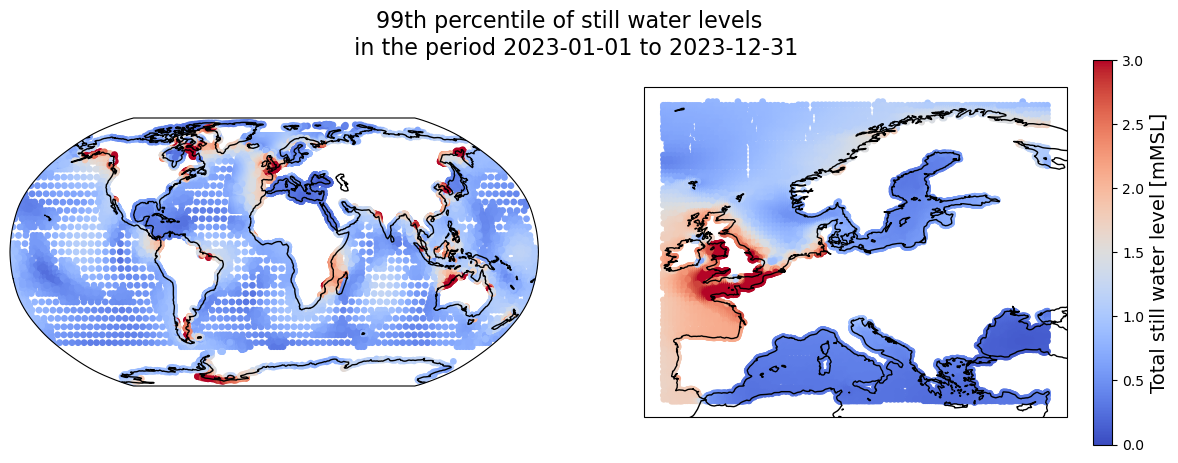

In [30]:
# select plot values range (colorbar limits)
lims = [0, 3]

# Initiate the plot with two subplots
fig = plt.figure(figsize=(15, 5))
ax0 = plt.subplot2grid((1, 2), (0, 0), projection=ccrs.Robinson())
ax1 = plt.subplot2grid((1, 2), (0, 1), projection=ccrs.PlateCarree())

# Plot the 2D maps with scatter - global map
im = ax0.scatter(x=ds_wl_q.station_x_coordinate, y=ds_wl_q.station_y_coordinate, s=15,
                 c=ds_wl_q['waterlevel'], transform=ccrs.PlateCarree(), cmap='coolwarm',
                 vmin=lims[0], vmax=lims[1])
ax0.coastlines(color='black')

# Plot the 2D maps with scatter - Europe map
im = ax1.scatter(x=ds_wl_eu_q.station_x_coordinate, y=ds_wl_eu_q.station_y_coordinate, s=15,
                 c=ds_wl_eu_q['waterlevel'], transform=ccrs.PlateCarree(), cmap='coolwarm',
                 vmin=lims[0], vmax=lims[1])
cbar = plt.colorbar(im)
cbar.set_label('Total still water level [mMSL]', fontsize=14)
ax1.coastlines(color='black')

# Add title
fig.suptitle(f"{int(quan*100)}th percentile of still water levels \n in the period" +
             f" {ds_wl.time.dt.strftime("%Y-%m-%d").values[0]} to " +
             f"{ds_wl.time.dt.strftime("%Y-%m-%d").values[-1]}", fontsize=16)

# Save the figure
fig.savefig(f'{OUTDIR}/map_waterlevel_perc{int(quan*100)}_{year}.png', dpi=300)

We can visualize the quantiles of the surge values in a similar way:

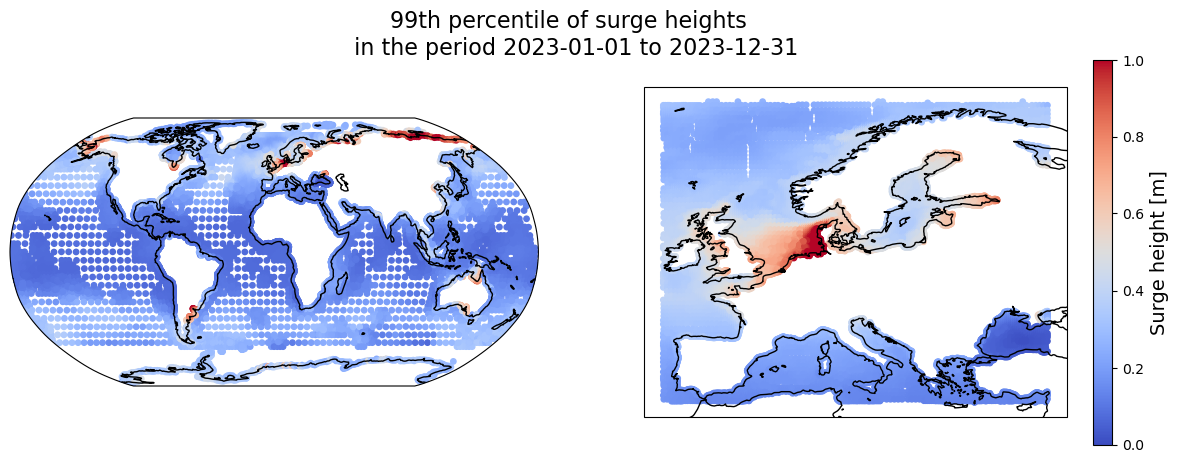

In [31]:
lims = [0, 1]

# Initiate the plot with two subplots
fig = plt.figure(figsize=(15, 5))
ax0 = plt.subplot2grid((1, 2), (0, 0), projection=ccrs.Robinson())
ax1 = plt.subplot2grid((1, 2), (0, 1), projection=ccrs.PlateCarree())

# Plot the 2D maps with scatter - global map
im = ax0.scatter(x=ds_sur_q.station_x_coordinate, y=ds_sur_q.station_y_coordinate, s=15,
                 c=ds_sur_q['surge'], transform=ccrs.PlateCarree(), cmap='coolwarm',
                 vmin=lims[0], vmax=lims[1])
ax0.coastlines(color='black')

# Plot the 2D maps with scatter - Europe map
im = ax1.scatter(x=ds_sur_eu_q.station_x_coordinate, y=ds_sur_eu_q.station_y_coordinate, s=15,
                 c=ds_sur_eu_q['surge'], transform=ccrs.PlateCarree(), cmap='coolwarm',
                 vmin=lims[0], vmax=lims[1])
cbar = plt.colorbar(im)
cbar.set_label('Surge height [m]', fontsize=14)
ax1.coastlines(color='black')

# Add title
fig.suptitle(f"{int(quan*100)}th percentile of surge heights \n in the period" +
             f" {ds_wl.time.dt.strftime("%Y-%m-%d").values[0]} to " +
             f"{ds_wl.time.dt.strftime("%Y-%m-%d").values[-1]}", fontsize=16)

# Save the figure
fig.savefig(f'{OUTDIR}/map_surge_perc{int(quan*100)}_{year}.png', dpi=300)

The visualizations above help us to understand where the highest water levels and surge levels occur in Europe during winter storms. The highest overall water levels are found at the coast of the UK and France near the English channel, where large tidal ranges are found. Highest surges, on the other hand, are found at the coasts of the North Sea, and especially in the Netherlands, Denmark and Germany, where a combination of factors related to the shallow bathymetry of the North Sea, shape of the coastline and dominant wind direction during winter storms produces the highest surges.

Note: on the global map we do not see large surge peaks in the tropical zone, where tropical cyclones can also cause large storm surges. This highlights one of the important limitations of the dataset: for modelling tropical cyclone water levels accurately a model with higher spatial resolution is often needed, and it needs to be forced with meteorological data that accurately represents extreme winds during tropical cyclones. The forcing that was currently used, namely the reanalysis ERA5 dataset, does not always represent the tropical cyclones accurately, especially in the case of relatively small cyclone systems with steep pressure gradients.

## Visualize timeseries of high water levels and surges for a specific location  

We can take a look at the data along the temporal dimension by visualizing timeseries for a single location. We do this for a specific location affected by a known large storm. A location was selected at the start of this notebook for each of the storm options.

First need to determine which specific station from our dataset is the closest to the location of interest. We determine this by searching for a location that has the smallest difference in coordinates compared to the location of interest (coordinates of which are stored in the `latlon` variable). 

In [32]:
# First, find the index of the grid point nearest a specific lat/lon
abslat = np.abs(ds_wl.station_y_coordinate.values-latlon[0])
abslon = np.abs(ds_wl.station_x_coordinate.values-latlon[1])
c = np.maximum(abslon, abslat)

([iloc]) = np.where(c == np.min(c))

# get station number in the dataset that corresponds to this location
station = ds_wl.stations.values[iloc[0]]

Once the station number has been determined, we can subset the datasets of water levels and surges to that specific location, and to the selected time period based on variables `starttime` and `endtime`:

In [33]:
# convert timeframe variables to datetime
datetime_start = datetime.strptime(f'{starttime} {year}', "%d %B %Y")
datetime_end = datetime.strptime(f'{endtime} {year}', "%d %B %Y")

# subset data to the selected location and time period
ds_wl_loc = ds_wl.sel(stations=station, time=slice(datetime_start, datetime_end), drop=True)
ds_sur_loc = ds_sur.sel(stations=station, time=slice(datetime_start, datetime_end), drop=True)
ds_tide_loc = ds_tide.sel(stations=station, time=slice(datetime_start, datetime_end), drop=True)

When plotting the timeseries, we are specifically interested in the maximum values that occurred during a storm. The maximum value can be extracted by subsetting the data array to the max. value of the water levels and saving it to variable `ds_wl_loc_max`:

In [34]:
# find water level maximum
ds_wl_loc.load()
ds_wl_loc_max = ds_wl_loc.where(ds_wl_loc.waterlevel == ds_wl_loc.waterlevel.max(),
                                drop=True).squeeze()

Now we are ready to create a plot of the timeseries. We create a plot with three panels: a map plot showing the location of interest on a map of Europe and timeseries plots of water levels and surge heights. The time axes of the latter two plots are centered around the maximum water level showing the selected time window around the maximum water level event.

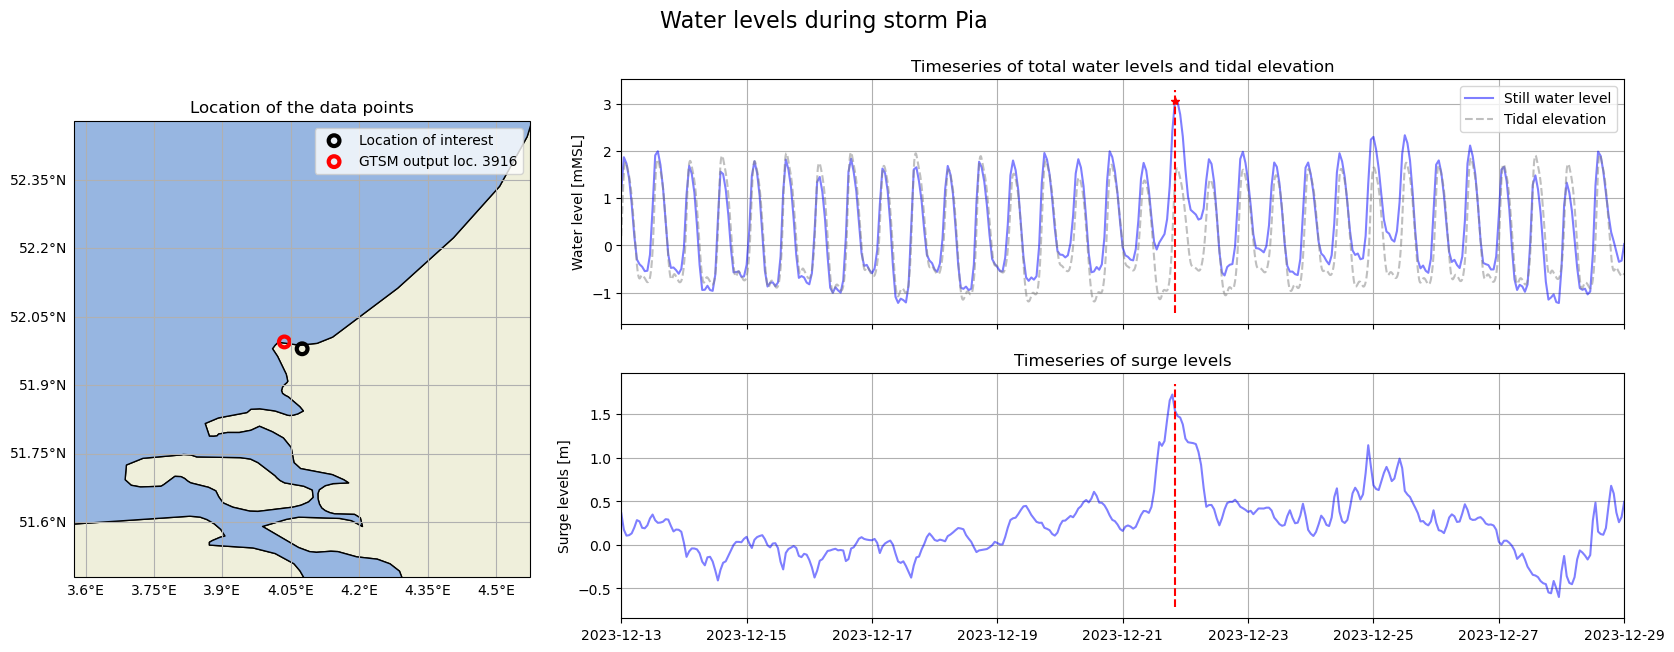

In [35]:
# plot timeseries of water levels and surges at the selected location
fig = plt.figure(figsize=(20, 7))
ax0 = plt.subplot2grid((2, 3), (0, 0), rowspan=2, projection=ccrs.PlateCarree())
ax1 = plt.subplot2grid((2, 3), (0, 1), colspan=2)
ax2 = plt.subplot2grid((2, 3), (1, 1), colspan=2)

#    plot location on the map
ax0.set_ylim([latlon[0]-0.5, latlon[0]+0.5])
ax0.set_xlim([latlon[1]-0.5, latlon[1]+0.5])
ax0.add_feature(cfeature.LAND, edgecolor='black')
ax0.add_feature(cfeature.OCEAN, edgecolor='black')
gl = ax0.gridlines(draw_labels=True)
gl.top_labels = gl.right_labels = False
bs = ax0.scatter(x=latlon[1], y=latlon[0], s=60, transform=ccrs.PlateCarree(), facecolors='None',
                 edgecolors='black', linewidth=3, label='Location of interest')
bs = ax0.scatter(x=ds_wl.sel(stations=station).station_x_coordinate.values,
                 y=ds_wl.sel(stations=station).station_y_coordinate.values,
                 s=60, transform=ccrs.PlateCarree(), facecolors='None', edgecolors='red',
                 linewidth=3, label=f'GTSM output loc. {station}')
ax0.title.set_text("Location of the data points")
ax0.legend()

# plot timeseries of water levels and tides
ts = ax1.plot(ds_wl_loc.time, ds_wl_loc.waterlevel, 'b-', alpha=0.5, label='Still water level')
ax1.plot(ds_tide_loc.time, ds_tide_loc.tide,
         color='grey', linestyle='--', alpha=0.5, label='Tidal elevation')
ax1.plot(ds_wl_loc.sel(time=ds_wl_loc_max.time).time,
         ds_wl_loc.sel(time=ds_wl_loc_max.time).waterlevel, 'r*')
ax1.plot([ds_wl_loc_max.time.values]*2, list(ax1.get_ylim()), 'r--')
ax1.set_ylabel('Water level [mMSL]')
ax1.grid()
ax1.title.set_text('Timeseries of total water levels and tidal elevation')
ax1.set_xticklabels([])
ax1.legend()

# plot timeseries of surge levels
ts = ax2.plot(ds_sur_loc.time, ds_sur_loc.surge, 'b-', alpha=0.5)
ax2.plot([ds_wl_loc_max.time.values]*2, list(ax2.get_ylim()), 'r--')
ax2.set_ylabel('Surge levels [m]')
ax2.grid()
ax2.title.set_text('Timeseries of surge levels')

# Set time axis limits to the selected time range
datetime_start = datetime.strptime(f'{starttime} {year}', "%d %B %Y")
datetime_end = datetime.strptime(f'{endtime} {year}', "%d %B %Y")
plt.setp([ax1, ax2], xlim=[datetime_start, datetime_end])
plt.suptitle(f'Water levels during storm {storm}', fontsize=16)

# Save the figure
fig.savefig(f'{OUTDIR}/timeseries_{storm}_{year}_loc_lat_{latlon[0]}_lon_{latlon[1]}.png', dpi=300)

To understand how water levels can vary spatially around the peak water level event, we can plot spatial maps of GTSM model output points for several hours leading up to the peak water levels at the location of interest, as well as several hours afterwards. The code below is used to first subset the data for plotting, and then to make a plot consisting of 9 panels, demonstrating water levels for 9 consequtive hours. 

In [36]:
# Selecting data for plotting

# Select area around the location of interest
bbox_arealoc = [latlon[1]-1.5, latlon[1]+1.5, latlon[0]-1.5, latlon[0]+1.5]
ds_wl.station_x_coordinate.load()
ds_wl.station_y_coordinate.load()
ds_wl_arealoc = ds_wl.where((ds_wl.station_x_coordinate > bbox_arealoc[0]) &
                            (ds_wl.station_x_coordinate < bbox_arealoc[1]) &
                            (ds_wl.station_y_coordinate > bbox_arealoc[2]) &
                            (ds_wl.station_y_coordinate < bbox_arealoc[3]), drop=True)

# Select the 9 hourly timesteps around the peak water level at location of interest
ds_wl_arealoc = ds_wl_arealoc.sel(time=slice(ds_wl_loc_max.time.values - np.timedelta64(4, 'h'),
                                  ds_wl_loc_max.time.values + np.timedelta64(4, 'h')), drop=True)
ds_wl_arealoc.load()  # load data into memory for faster plotting

<xarray.Dataset> Size: 15kB
Dimensions:               (time: 9, stations: 163)
Coordinates:
    station_x_coordinate  (stations) float64 1kB 2.629 2.703 ... 3.274 3.113
    station_y_coordinate  (stations) float64 1kB 51.13 51.16 ... 51.75 51.38
  * time                  (time) datetime64[ns] 72B 2023-12-21T16:00:00 ... 2...
  * stations              (stations) uint16 326B 3894 3895 3896 ... 41018 41019
Data variables:
    waterlevel            (time, stations) float64 12kB 1.162 1.054 ... 0.19
Attributes: (12/35)
    Conventions:                   CF-1.6
    featureType:                   timeSeries
    id:                            GTSMv3_totalwaterlevels
    naming_authority:              https://deltares.nl/en
    Metadata_Conventions:          Unidata Dataset Discovery v1.0
    title:                         Hourly timeseries of total water levels
    ...                            ...
    geospatial_vertical_max:       7.978
    geospatial_vertical_units:     m
    geospatial_vertical_positive:  up
    time_coverage_start:           2023-01-01 00:00:00
    time_coverage_end:             2023-01-31 23:00:00
    experiment:                    reanalysis

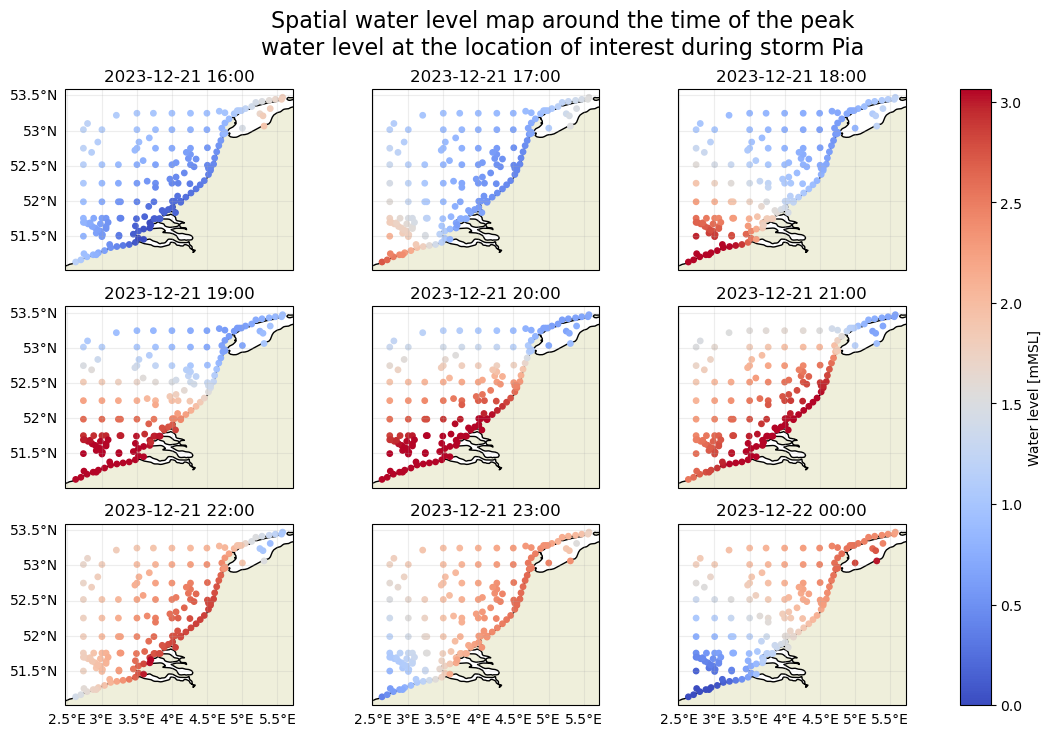

In [37]:
# Plotting the data

# Colorbar limits for total water levels based on the maximum value at the location of interest
lims = [0, ds_wl_loc_max.waterlevel.values.tolist()]

# Initiate the plot with four subplots
fig, axs = plt.subplots(nrows=3, ncols=3,
                        subplot_kw={'projection': ccrs.PlateCarree()},
                        figsize=(14, 8))
axs = axs.flatten()

# Loop over timesteps and plot each in a separate axis
for ii, timestamp in enumerate(ds_wl_arealoc.time.values):
    im = axs[ii].scatter(x=ds_wl_arealoc.station_x_coordinate, y=ds_wl_arealoc.station_y_coordinate,
                         s=15, c=ds_wl_arealoc['waterlevel'].sel(time=timestamp),
                         cmap='coolwarm', vmin=lims[0], vmax=lims[1])

    # Add land feature
    axs[ii].add_feature(cfeature.LAND, edgecolor='black')

    # add gridlines
    gl = axs[ii].gridlines(draw_labels=False, color='darkgrey', alpha=0.2)
    gl.left_labels = True if ii % 3 == 0 else False
    gl.bottom_labels = True if int(ii / 3) == 2 else False

    # add timestamp as title
    axs[ii].set_title(np.datetime_as_string(timestamp, unit='m').replace('T', ' '))

fig.colorbar(im, ax=axs.ravel().tolist(), label='Water level [mMSL]')

# Add title
fig.suptitle("Spatial water level map around the time of the peak\n" +
             f"water level at the location of interest during storm {storm}", fontsize=16)

# Save the figure
fig.savefig(f'{OUTDIR}/map_{storm}_{year}_loc_lat_{latlon[0]}_lon_{latlon[1]}.png', dpi=300)

From the plot above we can see how tidal propagation and surge generation during a storm generate high water levels at different locations along the coast.

### Understanding vertical reference level of the data

We have explored the waterlevel statistics for the given year and looked at timeseries of water levels during the selected winter storm. But what is the vertical reference on this data and how can one relate it to historical measurements?

The GTSMip data for water levels and tides is referenced to the mean sea level (MSL) at the given location. However, in the presence of sea level rise, MSL is a dynamic variable which will vary from year to year. The GTSMip dataset includes the effect of sea level rise, which is schematized by means of adding the sea level rise field, with annual increments (each year of model simulation is supplied with the estimated sea level rise field for that year). This sea level is based on a probabilistic model combining historical observations (up to 2015) and CMIP5 climate models (RCP8.5 scenario) for 2016 onwards. For more information and references please refer to the [Product User Guide](https://cds.climate.copernicus.eu/datasets/sis-water-level-change-timeseries-cmip6?tab=documentation).

In order to set a clear vertical reference, allowing to compare water levels between years, a reference MSL is set as the mean sea level over the period 1986-2005. Therefore, water levels and tides for each model output location are given in reference to the mean MSL across the period 1986-2005 at this location. 

To better understand this reference and check the contribution of the sea level rise to the total water levels, we can plot the MSL values for our location of interest for the period between 1985 and the year we are interested in. 

In [38]:
gtsm_msl_nc_rel = glob(f'{DATADIR}*msl*.nc')

gtsm_msl_nc = [os.path.basename(i) for i in gtsm_msl_nc_rel]

ds_msl = xr.open_mfdataset([os.path.join(DATADIR, x) for x in gtsm_msl_nc])

ds_msl_loc = ds_msl.sel(stations=station, drop=True)

Text(0.5, 1.0, 'Mean Sea Level at the location of interest \n Lat=51.98°N, Lon=4.075°E')

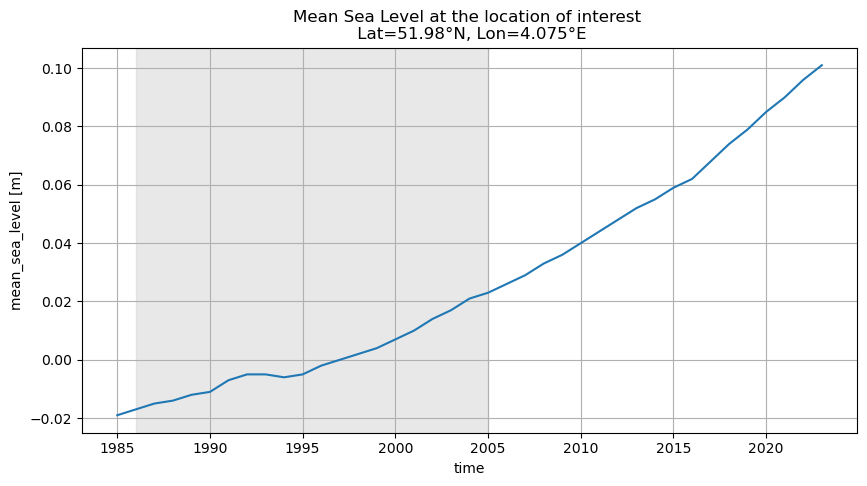

In [39]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 5))
ds_msl_loc['mean_sea_level'].plot(ax=ax)
ax.grid()
ylims = ax.get_ylim()
ax.fill_betweenx(ylims, [np.datetime64('1986')]*2, [np.datetime64('2005')]*2,
                 color='lightgrey', alpha=0.5)
ax.set_ylim(ylims)
ax.set_title(
    'Mean Sea Level at the location of interest \n' +
    f' Lat={latlon[0]}\N{DEGREE SIGN}N, Lon={latlon[1]}\N{DEGREE SIGN}E')

We can check that the mean MSL across period 1986-2005 is indeed close to zero by calculating it:

In [40]:
mean_1986_2005 = ds_msl_loc['mean_sea_level'].sel(time=slice('1986', '2005')).mean().values
print("Mean MSL value in the period 1986-2005 is equal to: %.2f m" % mean_1986_2005)

Mean MSL value in the period 1986-2005 is equal to: -0.00 m


We can also check what value of sea level rise is included in the runs for the year that contained the storm we are interested in, relative to the 1986-2005 baseline. While for recent years sea level rise is still a relatively small value, its importance will increase in the next decades, potentially leading to higher water levels during storms.

In [41]:
MSL_year = ds_msl_loc['mean_sea_level'].sel(time=str(year)).values.squeeze()
print("MSL in %i at the location of interest: %.2f m" % (year, MSL_year))

MSL in 2023 at the location of interest: 0.10 m


In conclusion, in this notebook we have explored the GTSMip dataset and applied it to better understand the dynamics of water levels during severe winter storms in Europe. By modifying and expanding on the examples provided in this notebook you can perform your own analysis for other locations.

<p></p>
<span style='float:right'><p style=\"text-align:right;\">This project is licensed under <a href="./LICENSE">APACHE License 2.0</a>. | <a href=\"https://github.com/ecmwf-projects/copernicus-training">View on GitHub</a></span>